In [83]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 1000)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression"
]

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ") and item_lvl_w_imp[x].sum() > 70] # All diagnosis columns
display(diag_cols)

['Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: No Diagnosis Given',
 'Diag: Autism Spectrum Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: ADHD-Combined Type',
 'Diag: ADHD-Inattentive Type',
 'Diag: Specific Phobia',
 'Diag: Separation Anxiety',
 'Diag: Language Disorder',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Oppositional Defiant Disorder',
 'Diag: Enuresis',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Major Depressive Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading']

In [84]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col, X_train, y_train):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(X_train, y_train) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [85]:
def find_best_classifier_for_diag(diag, X_train, y_train):
    base_models_and_param_grids = get_base_models_and_param_grids()
    best_classifiers_and_scores = []
    
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag, X_train, y_train)
        model_type = list(base_model.named_steps.keys())[-1]
        best_classifiers_and_scores.append([model_type, best_classifier_for_model, best_score_for_model])
    
    best_classifiers_and_scores = pd.DataFrame(best_classifiers_and_scores, columns = ["Model type", "Best classifier", "Best score"])
    display(best_classifiers_and_scores)
    best_classifier = best_classifiers_and_scores.sort_values("Best score", ascending=False)["Best classifier"].iloc[0]
    
    # If LogisticRegression is not much worse than the best model, prefer LogisticRegression (much faster than rest)
    best_base_model = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Model type"].iloc[0]
    if best_base_model != "logisticregression":
        best_score = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Best score"].iloc[0]
        lr_score = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best score"].iloc[0]
        print("lr_score: ", lr_score, "; best_score: ", best_score)
        e = 0.03
        if best_score - lr_score <= e:
            best_classifier = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best classifier"].iloc[0]
        
    print("best classifier:")
    print(best_classifier)
    
    return best_classifier

In [86]:
# Create datasets for each diagnosis (different input and output columns)

def customize_input_cols_per_diag(input_cols, diag):
    # Also remove "Diag: Intellectual Disability-Mild" when predicting "Diag: Borderline Intellectual Functioning"
    #   and vice versa
    if diag == "Diag: Intellectual Disability-Mild":
        input_cols = [x for x in input_cols if x != "Diag: Borderline Intellectual Functioning"]
    if diag == "Diag: Borderline Intellectual Functioning":
        input_cols = [x for x in input_cols if x != "Diag: Intellectual Disability-Mild"]
    if diag == "Diag: No Diagnosis Given":
        input_cols = [x for x in input_cols if not x.startswith("Diag: ")]
    if diag == "Diag: ADHD-Combined Type":
        input_cols = [x for x in input_cols if x not in ["Diag: ADHD-Inattentive Type", 
                                                         "Diag: ADHD-Hyperactive/Impulsive Type",
                                                         "Diag: Other Specified Attention-Deficit/Hyperactivity Disorder",
                                                         "Diag: Unspecified Attention-Deficit/Hyperactivity Disorder"]]
    if diag == "Diag: ADHD-Inattentive Type":
        input_cols = [x for x in input_cols if x not in ["Diag: ADHD-Combined Type", 
                                                         "ADHD-Hyperactive/Impulsive Type",
                                                         "Diag: Other Specified Attention-Deficit/Hyperactivity Disorder",
                                                         "Diag: Unspecified Attention-Deficit/Hyperactivity Disorder"]]
                      
    return input_cols

def get_input_and_output_cols_for_diag(diag):
    
    input_cols = [x for x in item_lvl_w_imp.columns if 
                        not x.startswith("WIAT")
                        and not x.startswith("WISC")
                        and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]
                        and not x == diag
                        and not x == "Diag: No Diagnosis Given"]
    
    input_cols = customize_input_cols_per_diag(input_cols, diag)
    
    output_col = diag
    
    return input_cols, output_col

datasets = {}
for diag in diag_cols:
    
    input_cols, output_col = get_input_and_output_cols_for_diag(diag)
    
    # Split train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=1)
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1) 

    datasets[diag] = { "X_train": X_train,
                       "X_test": X_test,
                       "y_train": y_train,
                       "y_test": y_test,
                       "X_train_train": X_train_train,
                       "X_val": X_val,
                       "y_train_train": y_train_train,
                       "y_val": y_val}

In [87]:
# Calculate probability threshold
beta = 2
def calculate_threshold(classifier, X_train_train, y_train_train, X_val, y_val, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(X_train_train, y_train_train)
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(X_val)
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [88]:
# Find best classifier
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        print(diag)

        X_train = datasets[diag]["X_train"]
        y_train = datasets[diag]["y_train"]
        
        best_classifier_for_diag = find_best_classifier_for_diag(diag, X_train, y_train)
        best_classifiers[diag] = best_classifier_for_diag
    print(best_classifiers)

Diag: Specific Learning Disorder with Impairment in Written Expression


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.7778052261747913 ; best_score:  0.7932155404981492
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.038220797163646444, penalty='l1',
                                    solver='liblinear'))])
Diag: No Diagnosis Given


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.813256587168269 ; best_score:  0.840894380700206
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.00021306487620947418,
                                    solver='liblinear'))])
Diag: Autism Spectrum Disorder


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001713335559333824,
                                    solver='liblinear'))])
Diag: Specific Learning Disorder with Impairment in Mathematics


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.05463695174955678, penalty='l1',
                                    solver='liblinear'))])
Diag: ADHD-Combined Type


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8715683711141744 ; best_score:  0.8785061267700858
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.018819044386953178, penalty='l1',
                                    solver='liblinear'))])
Diag: ADHD-Inattentive Type


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.7358786152754968 ; best_score:  0.7835315053400379
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=73, max_features=0.5,
                                        min_samples_leaf=10,
                                        min_samples_split=21,
                                        n_estimators=269))])
Diag: Specific Phobia


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.03309114231371118, penalty='l1',
                                    solver='liblinear'))])
Diag: Separation Anxiety


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0852737857615474, penalty='l1',
                                    solver='liblinear'))])
Diag: Language Disorder


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.7874954516772372 ; best_score:  0.8040405994420724
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.05637535161814645, penalty='l1',
                                    solver='liblinear'))])
Diag: Social Anxiety (Social Phobia)


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.09603183720598356, penalty='l1',
                                    solver='liblinear'))])
Diag: Oppositional Defiant Disorder


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8831986602470169 ; best_score:  0.8844076942758123
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0007221473084045357,
                                    solver='liblinear'))])
Diag: Enuresis


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.07771137164344681, penalty='l1',
                                    solver='liblinear'))])
Diag: Generalized Anxiety Disorder


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8262442788914206 ; best_score:  0.8287516818423605
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0713585994859021, penalty='l1',
                                    solver='liblinear'))])
Diag: Major Depressive Disorder


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8627409596172787 ; best_score:  0.8673352350009167
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.12696435727613717, penalty='l1',
                                    solver='liblinear'))])
Diag: Specific Learning Disorder with Impairment in Reading


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8194099462676442 ; best_score:  0.8358948069001492
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.053571369967335, penalty='l1',
                                    solver='liblinear'))])
{'Diag: Specific Learning Disorder with Impairment in Written Expression': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.038220797163646444, penalty='l1',
                                    solver='liblinear'))]), 'Diag: No Diagnosis Given': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.00021306487620947418,
    

In [89]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in best_classifiers:
        print(diag)
        best_classifier_for_diag = best_classifiers[diag]
        X_train_train, y_train_train, X_val, y_val = datasets[diag]["X_train_train"], datasets[diag]["y_train_train"], datasets[diag]["X_val"], datasets[diag]["y_val"]
        threshold = calculate_threshold(best_classifier_for_diag, X_train_train, y_train_train, X_val, y_val, beta)
        best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

Diag: Specific Learning Disorder with Impairment in Written Expression
Diag: No Diagnosis Given
Diag: Autism Spectrum Disorder
Diag: Specific Learning Disorder with Impairment in Mathematics
Diag: ADHD-Combined Type
Diag: ADHD-Inattentive Type
Diag: Specific Phobia
Diag: Separation Anxiety


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_66747/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


Diag: Language Disorder
Diag: Social Anxiety (Social Phobia)


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_66747/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


Diag: Oppositional Defiant Disorder
Diag: Enuresis


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_66747/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_66747/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


Diag: Generalized Anxiety Disorder
Diag: Major Depressive Disorder
Diag: Specific Learning Disorder with Impairment in Reading
{'Diag: Specific Learning Disorder with Impairment in Written Expression': 0.12037811768584837, 'Diag: No Diagnosis Given': 0.5213924139891556, 'Diag: Autism Spectrum Disorder': 0.584764509421088, 'Diag: Specific Learning Disorder with Impairment in Mathematics': 0.09984194103828438, 'Diag: ADHD-Combined Type': 0.4121901967548497, 'Diag: ADHD-Inattentive Type': 0.21134068935993267, 'Diag: Specific Phobia': 0.15204114603786573, 'Diag: Separation Anxiety': 0.07355525732568874, 'Diag: Language Disorder': 0.14291533729135322, 'Diag: Social Anxiety (Social Phobia)': 0.16227687871231672, 'Diag: Oppositional Defiant Disorder': 0.5001188393435807, 'Diag: Enuresis': 0.13458366405956354, 'Diag: Generalized Anxiety Disorder': 0.12680924995154436, 'Diag: Major Depressive Disorder': 0.1474675915564963, 'Diag: Specific Learning Disorder with Impairment in Reading': 0.1596832

In [90]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds 
    dump(best_classifiers, 'best-classifiers-cons-new-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-cons-new-item-lvl.joblib', compress=1)

In [91]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-cons-new-item-lvl.joblib')
    best_thresholds = load('best-thresholds-cons-new-item-lvl.joblib')

In [100]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall (Sensitivity)','FPR','FNR','TNR (Specificity)','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK','Predicted Positive Ratio']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FN) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    #DOR        = 1 # FIX, LINE ABOVE
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    Predicted_Positive_Ratio = round( (TP+FP) / Population,2)
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK,Predicted_Positive_Ratio]
    return (mat_met)

In [101]:
def get_metrics(classifier, threshold, X, y, print_output_flag = 0):
       
    y_pred_prob = classifier.predict_proba(X)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
        display = PrecisionRecallDisplay.from_predictions(y, y_pred_prob[:,1])
        display.ax_.set_title("Precision-Recall curve")
        plt.scatter(metrics[metric_names.index("Recall (Sensitivity)")], metrics[metric_names.index("Precision")], marker='o', color='black', label='Best')
        plt.show()
        
    return metrics

Diag: Specific Learning Disorder with Impairment in Written Expression


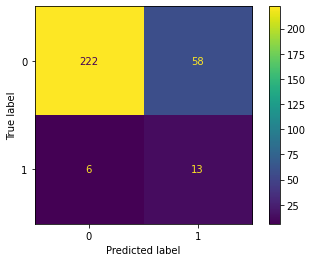

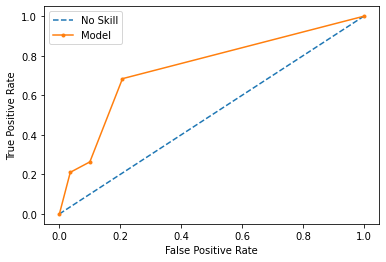

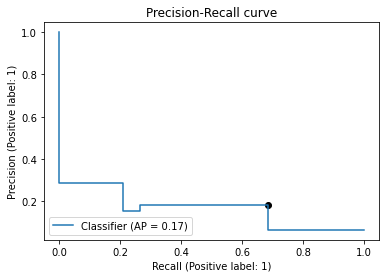

Diag: No Diagnosis Given


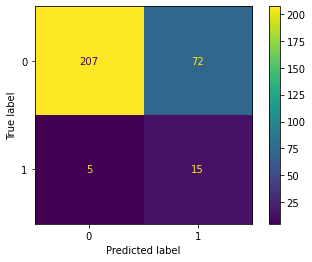

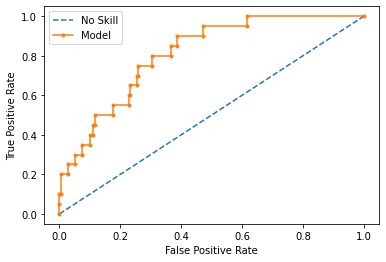

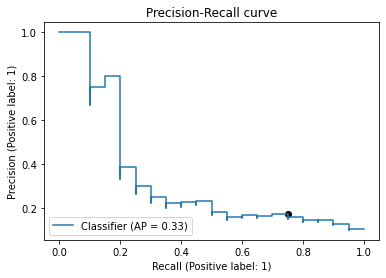

Diag: Autism Spectrum Disorder


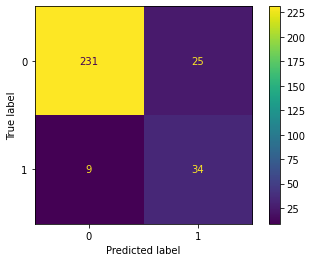

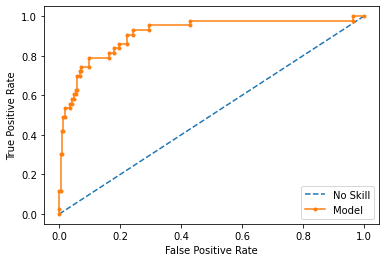

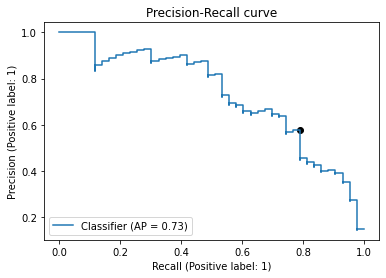

Diag: Specific Learning Disorder with Impairment in Mathematics


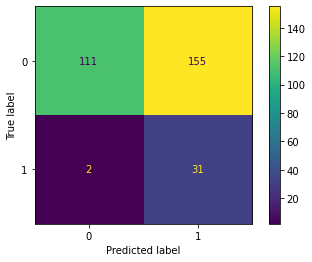

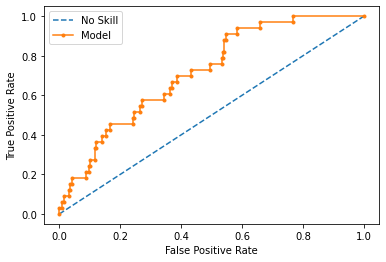

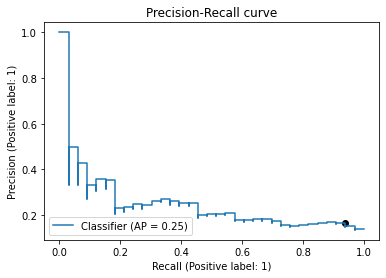

Diag: ADHD-Combined Type


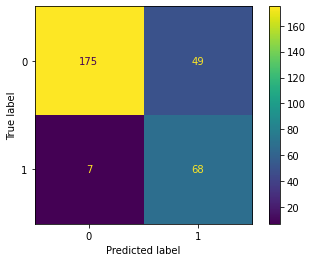

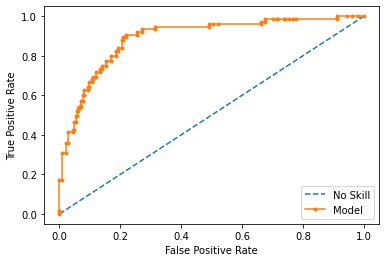

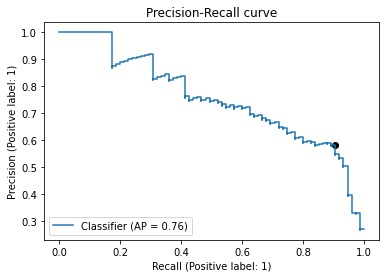

Diag: ADHD-Inattentive Type


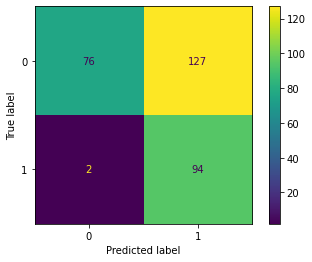

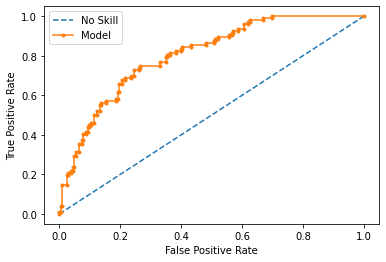

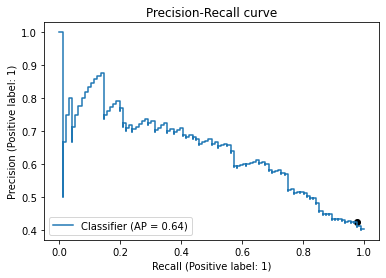

Diag: Specific Phobia


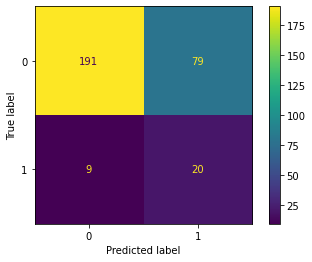

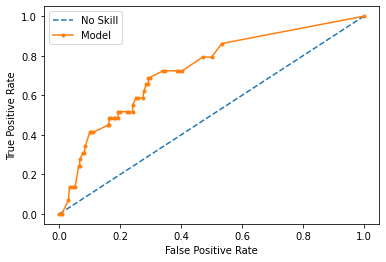

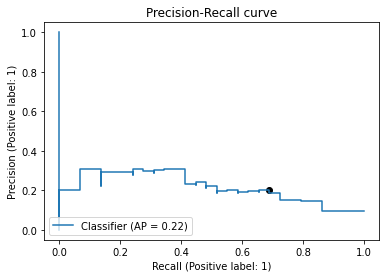

Diag: Separation Anxiety


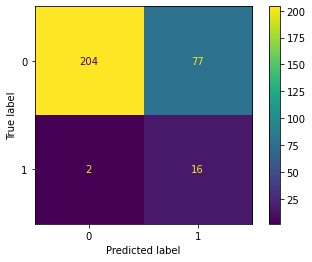

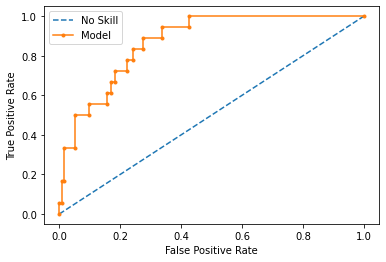

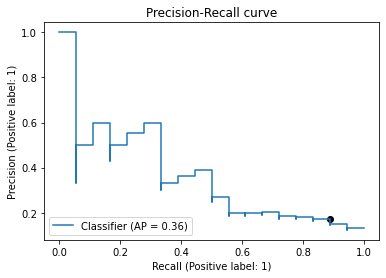

Diag: Language Disorder


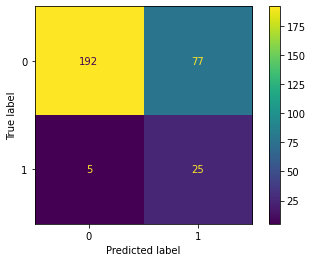

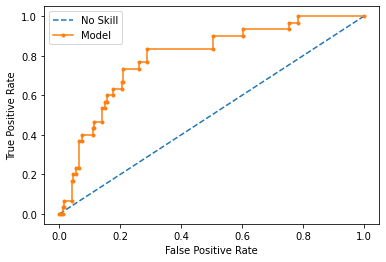

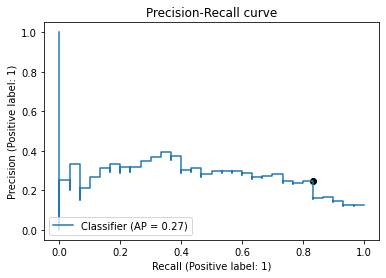

Diag: Social Anxiety (Social Phobia)


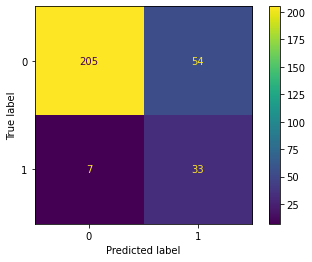

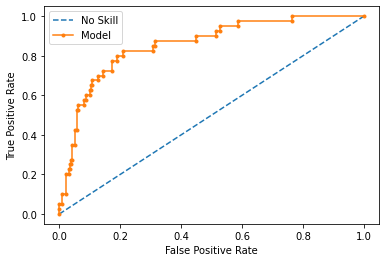

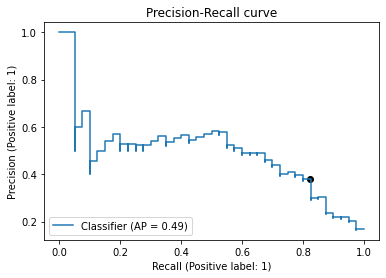

Diag: Oppositional Defiant Disorder


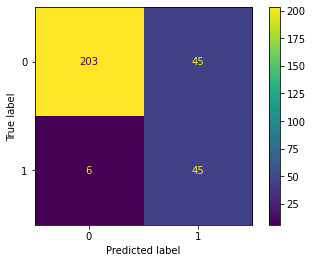

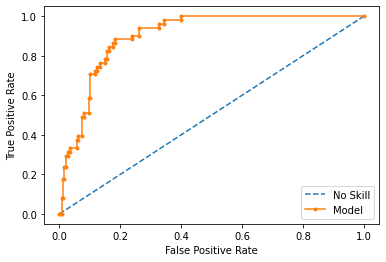

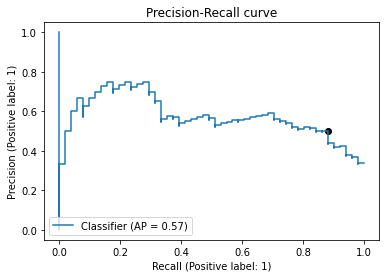

Diag: Enuresis


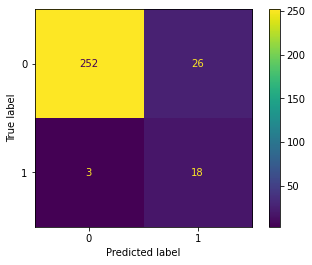

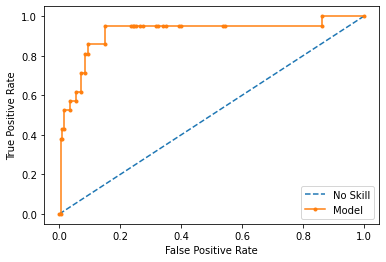

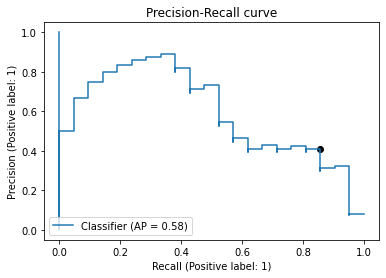

Diag: Generalized Anxiety Disorder


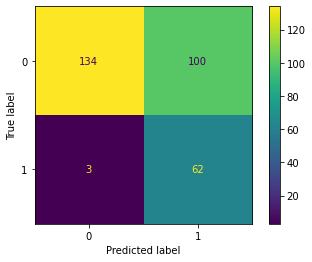

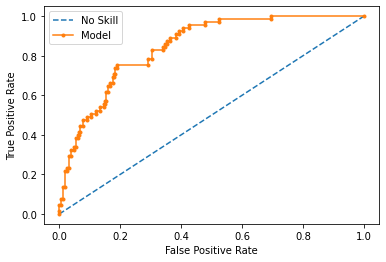

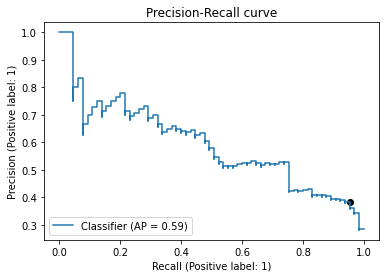

Diag: Major Depressive Disorder


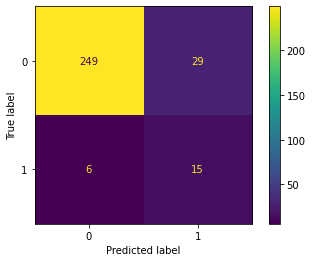

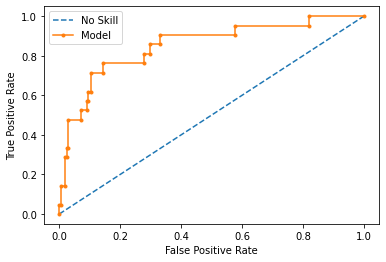

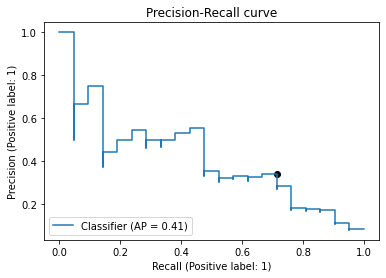

Diag: Specific Learning Disorder with Impairment in Reading


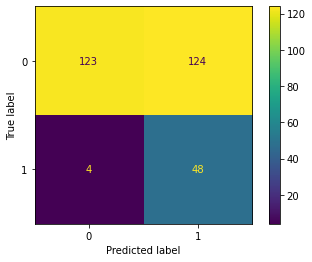

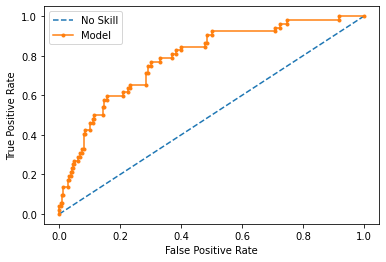

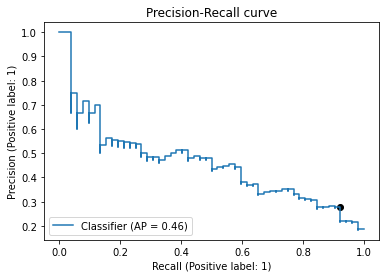

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC
11,Diag: Enuresis,18.01,252.01,26.01,3.01,0.07,0.90,0.41,0.99,0.59,1.18e-02,1.0,1.0,0.86,0.09,0.14,0.91,1.0,1.0,9.15,0.16,58,0.55,0.77,0.55,0.76,0.40,0.15,0.92
2,Diag: Autism Spectrum Disorder,34.01,231.01,25.01,9.01,0.14,0.89,0.58,0.96,0.42,3.75e-02,1.0,1.0,0.79,0.10,0.21,0.90,1.0,1.0,8.09,0.23,35,0.67,0.76,0.61,0.69,0.54,0.20,0.91
10,Diag: Oppositional Defiant Disorder,45.01,203.01,45.01,6.01,0.17,0.83,0.50,0.97,0.50,2.88e-02,1.0,1.0,0.88,0.18,0.12,0.82,1.0,1.0,4.86,0.14,34,0.64,0.82,0.57,0.70,0.47,0.30,0.90
4,Diag: ADHD-Combined Type,68.01,175.01,49.01,7.01,0.25,0.81,0.58,0.96,0.42,3.85e-02,1.0,1.0,0.91,0.22,0.09,0.78,1.0,1.0,4.14,0.12,35,0.71,0.86,0.61,0.69,0.54,0.39,0.89
7,Diag: Separation Anxiety,16.01,204.01,77.01,2.01,0.06,0.74,0.17,0.99,0.83,9.80e-03,1.0,1.0,0.89,0.27,0.11,0.73,1.0,1.0,3.24,0.15,21,0.29,0.63,0.32,0.61,0.16,0.31,0.87
9,Diag: Social Anxiety (Social Phobia),33.01,205.01,54.01,7.01,0.13,0.80,0.38,0.97,0.62,3.31e-02,1.0,1.0,0.82,0.21,0.18,0.79,1.0,1.0,3.96,0.22,18,0.52,0.74,0.46,0.62,0.35,0.29,0.86
13,Diag: Major Depressive Disorder,15.01,249.01,29.01,6.01,0.07,0.88,0.34,0.98,0.66,2.36e-02,1.0,1.0,0.71,0.10,0.29,0.90,1.0,1.0,6.85,0.32,21,0.46,0.64,0.44,0.61,0.32,0.15,0.85
12,Diag: Generalized Anxiety Disorder,62.01,134.01,100.01,3.01,0.22,0.66,0.38,0.98,0.62,2.20e-02,1.0,1.0,0.95,0.43,0.05,0.57,1.0,1.0,2.23,0.08,28,0.55,0.83,0.44,0.53,0.36,0.54,0.85
1,Diag: No Diagnosis Given,15.01,207.01,72.01,5.01,0.07,0.74,0.17,0.98,0.83,2.36e-02,1.0,1.0,0.75,0.26,0.25,0.74,1.0,1.0,2.91,0.34,9,0.28,0.56,0.27,0.49,0.15,0.29,0.81
5,Diag: ADHD-Inattentive Type,94.01,76.01,127.01,2.01,0.32,0.57,0.43,0.97,0.57,2.58e-02,1.0,1.0,0.98,0.63,0.02,0.37,1.0,1.0,1.57,0.06,28,0.59,0.87,0.38,0.35,0.40,0.74,0.80


In [102]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in best_classifiers:
    print(diag)
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_val, y_val = datasets[diag]["X_val"], datasets[diag]["y_val"]
    metrics = get_metrics(classifier, threshold, X_val, y_val, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_val_set.append([
        diag, 
        *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [103]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in best_classifiers:
    
    print(diag)
    
    classifier = best_classifiers[diag]

    cv = StratifiedKFold(n_splits=5)
    X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
    auc = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    auc_cv_mean_val_set.append(auc.mean())
    auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

Diag: Specific Learning Disorder with Impairment in Written Expression
Diag: No Diagnosis Given
Diag: Autism Spectrum Disorder
Diag: Specific Learning Disorder with Impairment in Mathematics
Diag: ADHD-Combined Type
Diag: ADHD-Inattentive Type
Diag: Specific Phobia
Diag: Separation Anxiety
Diag: Language Disorder
Diag: Social Anxiety (Social Phobia)
Diag: Oppositional Defiant Disorder
Diag: Enuresis
Diag: Generalized Anxiety Disorder
Diag: Major Depressive Disorder
Diag: Specific Learning Disorder with Impairment in Reading


,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Specific Learning Disorder with Impairment in Written Expression,13.01,222.01,58.01,6.01,0.06,0.79,0.18,0.97,0.82,2.64e-02,1.0,1.0,0.68,0.21,0.32,0.79,1.0,1.0,3.30,0.40,8,0.29,0.54,0.27,0.48,0.16,0.24,0.74,0.77,0.08
1,Diag: No Diagnosis Given,15.01,207.01,72.01,5.01,0.07,0.74,0.17,0.98,0.83,2.36e-02,1.0,1.0,0.75,0.26,0.25,0.74,1.0,1.0,2.91,0.34,9,0.28,0.56,0.27,0.49,0.15,0.29,0.81,0.81,0.04
2,Diag: Autism Spectrum Disorder,34.01,231.01,25.01,9.01,0.14,0.89,0.58,0.96,0.42,3.75e-02,1.0,1.0,0.79,0.10,0.21,0.90,1.0,1.0,8.09,0.23,35,0.67,0.76,0.61,0.69,0.54,0.20,0.91,0.91,0.03
3,Diag: Specific Learning Disorder with Impairment in Mathematics,31.01,111.01,155.01,2.01,0.11,0.47,0.17,0.98,0.83,1.78e-02,1.0,1.0,0.94,0.58,0.06,0.42,1.0,1.0,1.61,0.15,11,0.28,0.64,0.23,0.36,0.15,0.62,0.72,0.78,0.05
4,Diag: ADHD-Combined Type,68.01,175.01,49.01,7.01,0.25,0.81,0.58,0.96,0.42,3.85e-02,1.0,1.0,0.91,0.22,0.09,0.78,1.0,1.0,4.14,0.12,35,0.71,0.86,0.61,0.69,0.54,0.39,0.89,0.87,0.02
5,Diag: ADHD-Inattentive Type,94.01,76.01,127.01,2.01,0.32,0.57,0.43,0.97,0.57,2.58e-02,1.0,1.0,0.98,0.63,0.02,0.37,1.0,1.0,1.57,0.06,28,0.59,0.87,0.38,0.35,0.40,0.74,0.80,0.78,0.03
6,Diag: Specific Phobia,20.01,191.01,79.01,9.01,0.10,0.71,0.20,0.95,0.80,4.50e-02,1.0,1.0,0.69,0.29,0.31,0.71,1.0,1.0,2.36,0.44,5,0.31,0.56,0.25,0.40,0.16,0.33,0.73,0.72,0.07
7,Diag: Separation Anxiety,16.01,204.01,77.01,2.01,0.06,0.74,0.17,0.99,0.83,9.80e-03,1.0,1.0,0.89,0.27,0.11,0.73,1.0,1.0,3.24,0.15,21,0.29,0.63,0.32,0.61,0.16,0.31,0.87,0.81,0.06
8,Diag: Language Disorder,25.01,192.01,77.01,5.01,0.10,0.73,0.25,0.97,0.75,2.54e-02,1.0,1.0,0.83,0.29,0.17,0.71,1.0,1.0,2.91,0.23,12,0.38,0.67,0.35,0.55,0.22,0.34,0.79,0.80,0.02
9,Diag: Social Anxiety (Social Phobia),33.01,205.01,54.01,7.01,0.13,0.80,0.38,0.97,0.62,3.31e-02,1.0,1.0,0.82,0.21,0.18,0.79,1.0,1.0,3.96,0.22,18,0.52,0.74,0.46,0.62,0.35,0.29,0.86,0.84,0.02


In [104]:
for diag in best_classifiers:
    print(diag)
    print(list(best_classifiers[diag].named_steps.keys())[-1])
    if list(best_classifiers[diag].named_steps.keys())[-1] == "randomforestclassifier":
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].feature_importances_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, importances), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])
    else:
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].coef_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, abs(importances[0])), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])

Diag: Specific Learning Disorder with Impairment in Written Expression
logisticregression


,Feature,Importance
954,Diag: Specific Learning Disorder with Impairment in Mathematics,0.36
1008,Diag: Specific Learning Disorder with Impairment in Reading,0.17
671,"APQ_SR,APQ_SR_20",0.00
677,"APQ_SR,APQ_SR_25",0.00
676,"APQ_SR,APQ_SR_24",0.00
675,"APQ_SR,APQ_SR_23",0.00
674,"APQ_SR,APQ_SR_22",0.00
673,"APQ_SR,APQ_SR_21",0.00
672,"APQ_SR,APQ_SR_20A",0.00
0,"Basic_Demos,Age",0.00


Diag: No Diagnosis Given
logisticregression


,Feature,Importance
6,"NIH_Scores,NIH7_Pattern",4.67e-03
4,"NIH_Scores,NIH7_Flanker",4.25e-03
76,"SympChck,CSC_35P",4.20e-03
74,"SympChck,CSC_34P",4.11e-03
73,"SympChck,CSC_34C",4.07e-03
583,"ESWAN,MDD_8A",3.99e-03
451,"ICU_P,ICU_P_10",3.58e-03
2,"NIH_Scores,NIH7_Card",3.56e-03
330,"CBCL,CBCL_08",3.53e-03
75,"SympChck,CSC_35C",3.51e-03


Diag: Autism Spectrum Disorder
logisticregression


,Feature,Importance
176,"ASSQ,ASSQ_03",0.05
147,"SCQ,SCQ_15",0.05
197,"ASSQ,ASSQ_24",0.04
145,"SCQ,SCQ_13",0.04
310,"SRS,SRS_53",0.04
101,"SympChck,CSC_48C",0.04
179,"ASSQ,ASSQ_06",0.04
184,"ASSQ,ASSQ_11",0.03
427,"CBCL,CBCL_85",0.03
187,"ASSQ,ASSQ_14",0.03


Diag: Specific Learning Disorder with Impairment in Mathematics
logisticregression


,Feature,Importance
942,Diag: Specific Learning Disorder with Impairment in Written Expression,0.37
1008,Diag: Specific Learning Disorder with Impairment in Reading,0.26
973,Diag: Language Disorder,0.23
919,"C3SR,C3SR_38",0.18
4,"NIH_Scores,NIH7_Flanker",0.14
837,"SCARED_SR,SCARED_SR_03",0.10
805,"PhenX_Neighborhood,PhenX_NS_02",0.09
283,"SRS,SRS_25",0.08
961,Diag: Panic Disorder,0.04
937,Diag: Agoraphobia,0.04


Diag: ADHD-Combined Type
logisticregression


,Feature,Importance
258,"SWAN,SWAN_18",0.27
209,"SDQ,SDQ_02",0.26
251,"SWAN,SWAN_11",0.15
80,"SympChck,CSC_37P",0.14
435,"CBCL,CBCL_93",0.08
332,"CBCL,CBCL_10",0.05
256,"SWAN,SWAN_16",0.05
715,"CIS_P,CIS_P_05",0.04
376,"CBCL,CBCL_41",0.02
759,"PSI,PSI_36",0.02


Diag: ADHD-Inattentive Type
randomforestclassifier


,Feature,Importance
247,"SWAN,SWAN_07",0.09
254,"SWAN,SWAN_14",0.05
252,"SWAN,SWAN_12",0.03
244,"SWAN,SWAN_04",0.02
245,"SWAN,SWAN_05",0.02
253,"SWAN,SWAN_13",0.02
251,"SWAN,SWAN_11",0.01
76,"SympChck,CSC_35P",0.01
526,"PCIAT,PCIAT_19",0.01
583,"ESWAN,MDD_8A",0.01


Diag: Specific Phobia
logisticregression


,Feature,Importance
50,"SympChck,CSC_22P",1.37e-01
364,"CBCL,CBCL_29",9.71e-02
49,"SympChck,CSC_22C",4.48e-02
231,"SDQ,SDQ_24",1.92e-02
194,"ASSQ,ASSQ_21",2.60e-03
692,"APQ_SR,APQ_SR_39",0.00e+00
680,"APQ_SR,APQ_SR_27",0.00e+00
669,"APQ_SR,APQ_SR_18",0.00e+00
670,"APQ_SR,APQ_SR_19",0.00e+00
671,"APQ_SR,APQ_SR_20",0.00e+00


Diag: Separation Anxiety
logisticregression


,Feature,Importance
39,"SympChck,CSC_17C",0.22
38,"SympChck,CSC_16P",0.21
301,"SRS,SRS_43",0.20
42,"SympChck,CSC_18P",0.17
718,"CIS_P,CIS_P_08",0.17
56,"SympChck,CSC_25P",0.12
969,Diag: Sibling Relational Problem,0.10
241,"SWAN,SWAN_01",0.10
51,"SympChck,CSC_23C",0.09
698,"WHODAS_P,WHODAS_P_03",0.08


Diag: Language Disorder
logisticregression


,Feature,Importance
955,Diag: Specific Learning Disorder with Impairment in Mathematics,0.30
5,"NIH_Scores,NIH7_List",0.18
912,"C3SR,C3SR_31",0.16
156,"SCQ,SCQ_24",0.14
741,"PSI,PSI_18",0.14
964,Diag: Speech Sound Disorder,0.13
168,"SCQ,SCQ_36",0.12
611,"MFQ_P,MFQ_P_01",0.12
421,"CBCL,CBCL_79",0.11
385,"CBCL,CBCL_50",0.09


Diag: Social Anxiety (Social Phobia)
logisticregression


,Feature,Importance
45,"SympChck,CSC_20C",0.31
417,"CBCL,CBCL_75",0.24
85,"SympChck,CSC_40C",0.22
256,"SWAN,SWAN_16",0.21
413,"CBCL,CBCL_71",0.19
14,"SympChck,CSC_04P",0.18
276,"SRS,SRS_18",0.18
998,Diag: Generalized Anxiety Disorder,0.18
332,"CBCL,CBCL_10",0.17
105,"SympChck,CSC_50C",0.16


Diag: Oppositional Defiant Disorder
logisticregression


,Feature,Importance
91,"SympChck,CSC_43C",0.02
92,"SympChck,CSC_43P",0.02
84,"SympChck,CSC_39P",0.02
350,"CBCL,CBCL_15",0.02
445,"ICU_P,ICU_P_04",0.02
361,"CBCL,CBCL_26",0.02
356,"CBCL,CBCL_21",0.02
357,"CBCL,CBCL_22",0.02
747,"PSI,PSI_24",0.02
94,"SympChck,CSC_44P",0.02


Diag: Enuresis
logisticregression


,Feature,Importance
341,"CBCL,CBCL_108",0.74
62,"SympChck,CSC_28P",0.36
32,"SympChck,CSC_13P",0.12
129,"SympChck,CSC_55hC",0.10
631,"MFQ_P,MFQ_P_21",0.10
910,"C3SR,C3SR_29",0.08
953,Diag: Substance/Medication-Induced Bipolar and Related Disorder,0.08
302,"SRS,SRS_44",0.07
958,Diag: Conduct Disorder-Adolescent-onset type,0.07
194,"ASSQ,ASSQ_21",0.06


Diag: Generalized Anxiety Disorder
logisticregression


,Feature,Importance
215,"SDQ,SDQ_08",0.28
346,"CBCL,CBCL_112",0.24
1005,Diag: Other Specified Anxiety Disorder,0.23
52,"SympChck,CSC_23P",0.22
1003,Diag: Major Depressive Disorder,0.21
718,"CIS_P,CIS_P_08",0.21
982,Diag: Social Anxiety (Social Phobia),0.17
168,"SCQ,SCQ_36",0.16
60,"SympChck,CSC_27P",0.13
779,"RBS,RBS_20",0.12


Diag: Major Depressive Disorder
logisticregression


,Feature,Importance
8,"SympChck,CSC_01P",0.45
1,"Basic_Demos,Sex",0.23
714,"CIS_P,CIS_P_04",0.21
235,"SDQ,SDQ_28",0.17
66,"SympChck,CSC_30P",0.16
652,"APQ_SR,APQ_SR_06",0.16
999,Diag: Generalized Anxiety Disorder,0.15
968,Diag: Persistent Depressive Disorder (Dysthymia),0.14
0,"Basic_Demos,Age",0.14
645,"APQ_SR,APQ_SR_01",0.13


Diag: Specific Learning Disorder with Impairment in Reading
logisticregression


,Feature,Importance
914,"C3SR,C3SR_33",0.67
955,Diag: Specific Learning Disorder with Impairment in Mathematics,0.31
919,"C3SR,C3SR_38",0.31
942,Diag: Specific Learning Disorder with Impairment in Written Expression,0.25
894,"C3SR,C3SR_13",0.24
826,"CIS_SR,CIS_SR_05",0.11
741,"PSI,PSI_18",0.10
655,"APQ_SR,APQ_SR_08",0.10
383,"CBCL,CBCL_48",0.09
0,"Basic_Demos,Age",0.07


Diag: Specific Learning Disorder with Impairment in Written Expression


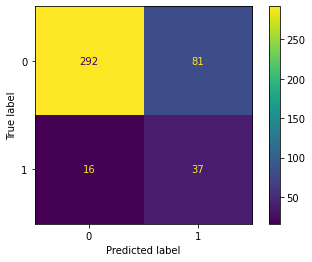

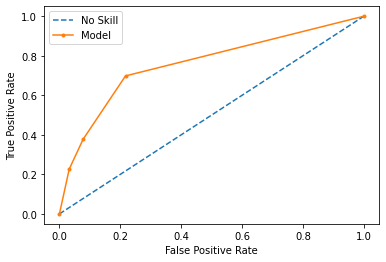

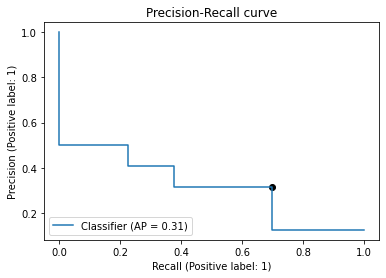

Diag: No Diagnosis Given


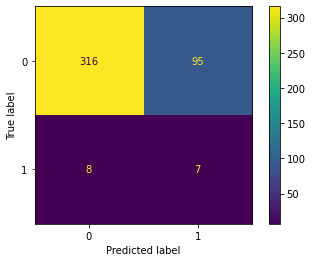

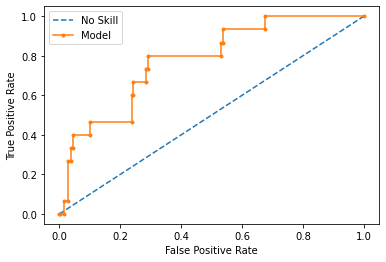

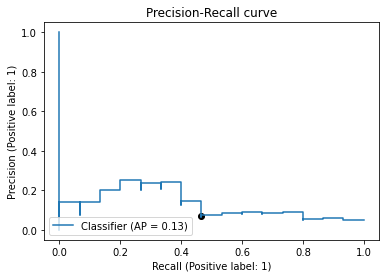

Diag: Autism Spectrum Disorder


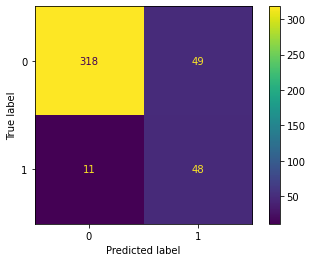

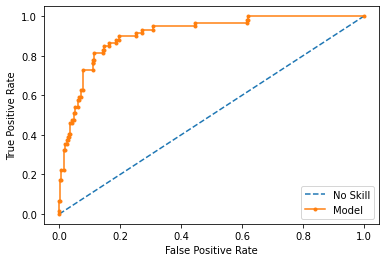

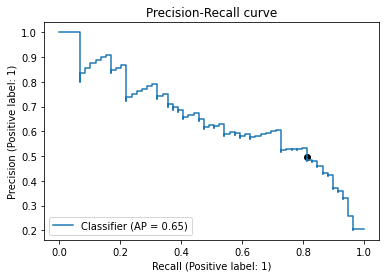

Diag: Specific Learning Disorder with Impairment in Mathematics


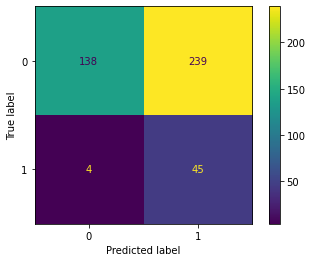

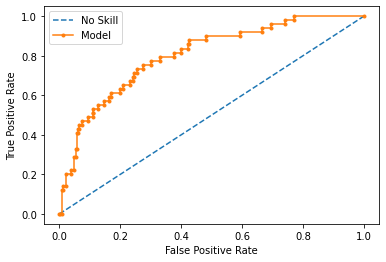

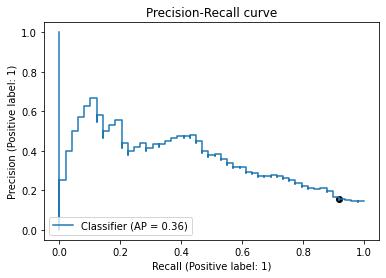

Diag: ADHD-Combined Type


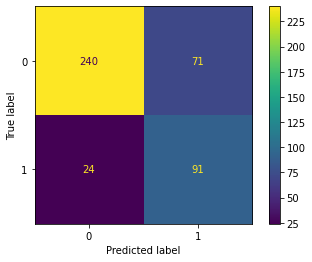

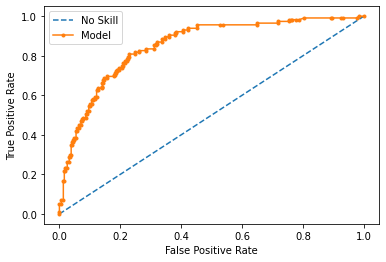

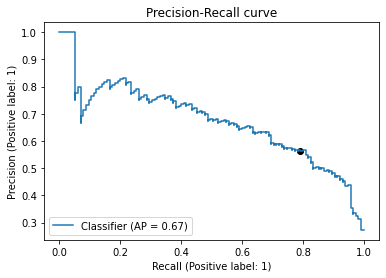

Diag: ADHD-Inattentive Type


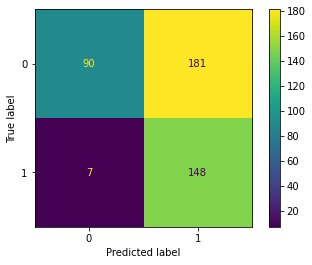

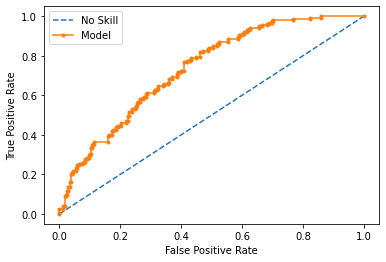

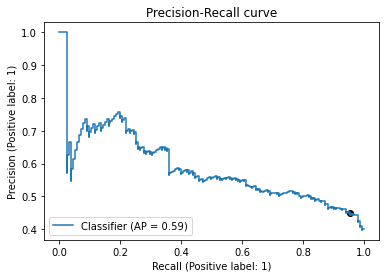

Diag: Specific Phobia


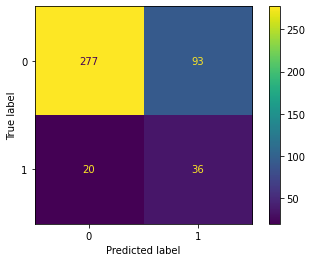

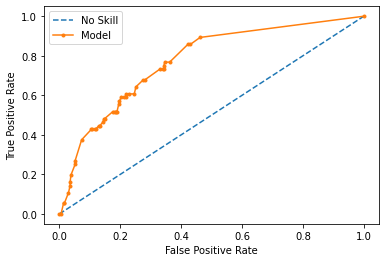

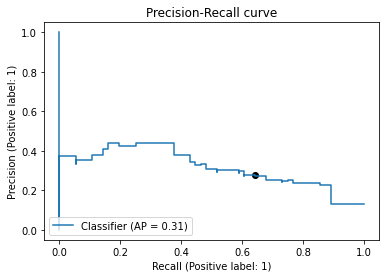

Diag: Separation Anxiety


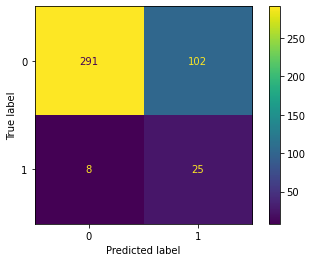

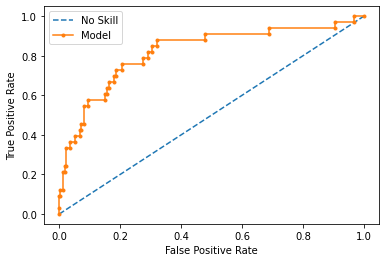

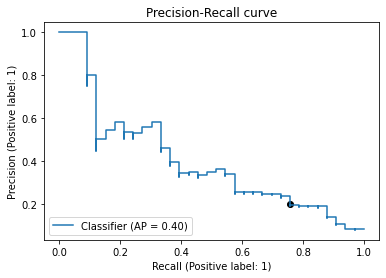

Diag: Language Disorder


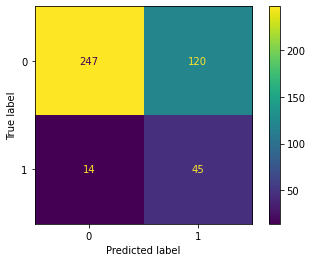

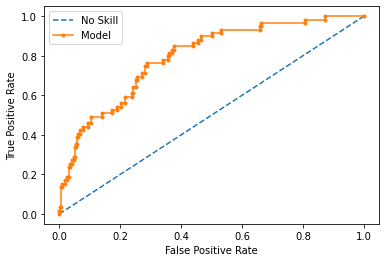

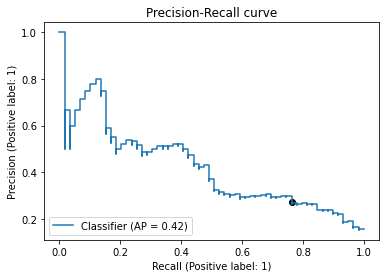

Diag: Social Anxiety (Social Phobia)


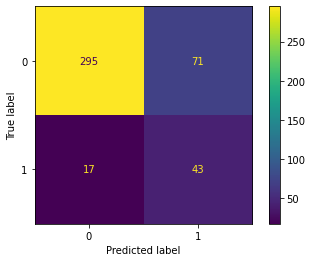

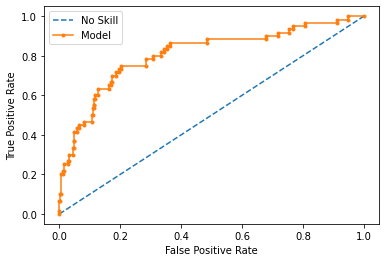

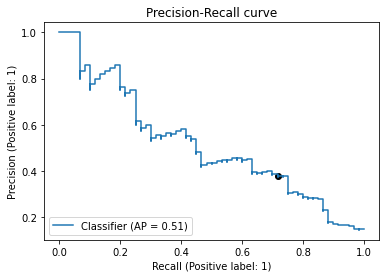

Diag: Oppositional Defiant Disorder


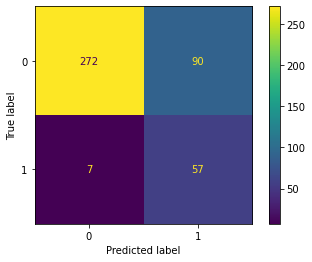

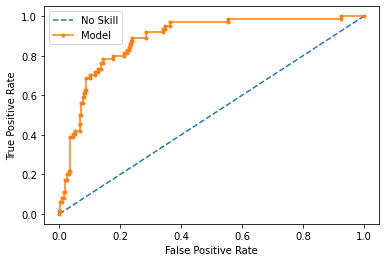

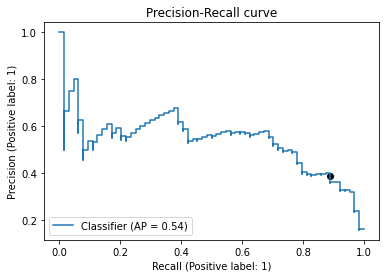

Diag: Enuresis


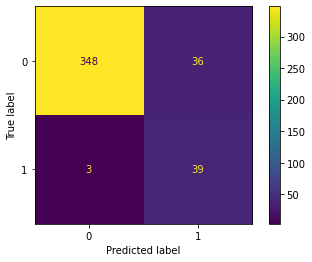

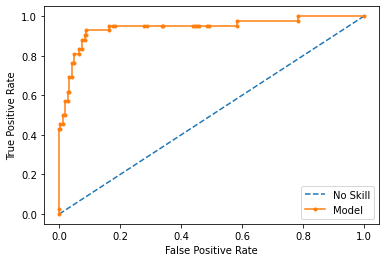

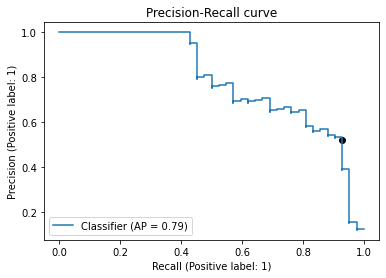

Diag: Generalized Anxiety Disorder


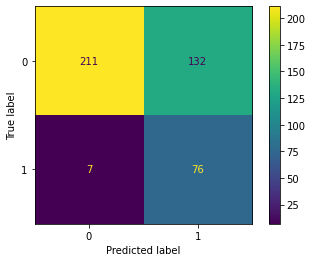

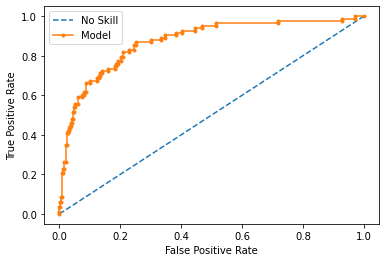

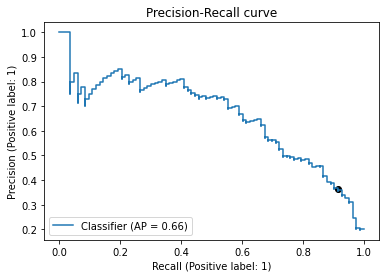

Diag: Major Depressive Disorder


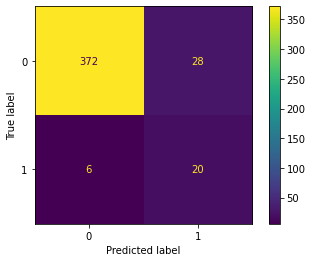

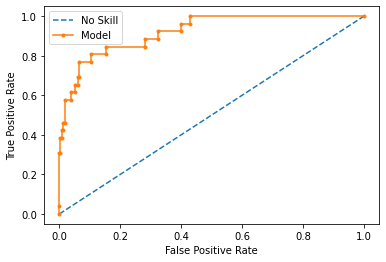

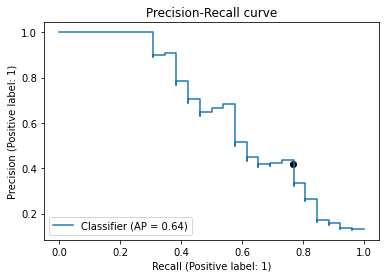

Diag: Specific Learning Disorder with Impairment in Reading


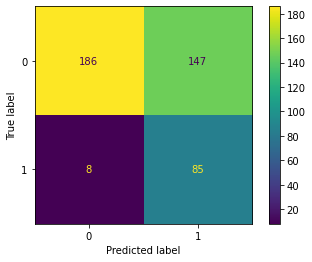

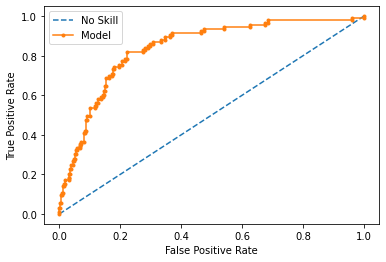

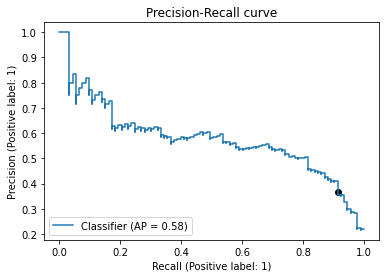

,Diag,Recall (Sensitivity),TNR (Specificity),Predicted Positive Ratio,ROC AUC
13,Diag: Major Depressive Disorder,0.77,0.93,0.11,0.92
11,Diag: Enuresis,0.93,0.91,0.18,0.94
2,Diag: Autism Spectrum Disorder,0.81,0.87,0.23,0.91
9,Diag: Social Anxiety (Social Phobia),0.72,0.81,0.27,0.81
0,Diag: Specific Learning Disorder with Impairment in Written Expression,0.70,0.78,0.28,0.76
4,Diag: ADHD-Combined Type,0.79,0.77,0.38,0.85
1,Diag: No Diagnosis Given,0.47,0.77,0.24,0.78
10,Diag: Oppositional Defiant Disorder,0.89,0.75,0.35,0.88
6,Diag: Specific Phobia,0.64,0.75,0.30,0.77
7,Diag: Separation Anxiety,0.76,0.74,0.30,0.82


In [106]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in best_classifiers:
    
    print(diag)
    
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]
    metrics = get_metrics(classifier, threshold, X_test, y_test, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_test_set.append([
        diag, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])

In [107]:
restults_test_set_df[["Diag", "Recall (Sensitivity)", "TNR (Specificity)", "Predicted Positive Ratio", "ROC AUC"]].sort_values(by="ROC AUC", ascending=False)

,Diag,Recall (Sensitivity),TNR (Specificity),Predicted Positive Ratio,ROC AUC
11,Diag: Enuresis,0.93,0.91,0.18,0.94
13,Diag: Major Depressive Disorder,0.77,0.93,0.11,0.92
2,Diag: Autism Spectrum Disorder,0.81,0.87,0.23,0.91
10,Diag: Oppositional Defiant Disorder,0.89,0.75,0.35,0.88
12,Diag: Generalized Anxiety Disorder,0.92,0.62,0.49,0.87
4,Diag: ADHD-Combined Type,0.79,0.77,0.38,0.85
14,Diag: Specific Learning Disorder with Impairment in Reading,0.91,0.56,0.54,0.84
7,Diag: Separation Anxiety,0.76,0.74,0.30,0.82
9,Diag: Social Anxiety (Social Phobia),0.72,0.81,0.27,0.81
3,Diag: Specific Learning Disorder with Impairment in Mathematics,0.92,0.37,0.67,0.80


### Feature importance

In [112]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - CV AUC Std) > 0.65, F1 Beta > 0.5, and FPR < 0.6

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)  & (restults_val_set_df["FPR"] < 0.6)]["Diag"]) 
display(diags_with_good_performance)
print(len(diags_with_good_performance), " / ", len(best_classifiers.keys()))
print(set(best_classifiers.keys()) - set(diags_with_good_performance))

['Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: No Diagnosis Given',
 'Diag: Autism Spectrum Disorder',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: ADHD-Combined Type',
 'Diag: Separation Anxiety',
 'Diag: Language Disorder',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Oppositional Defiant Disorder',
 'Diag: Enuresis',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Major Depressive Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading']

13  /  15
{'Diag: Specific Phobia', 'Diag: ADHD-Inattentive Type'}


In [113]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-cons-new-item-lvl.joblib')
    except Exception as e: print(e)

In [114]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

Diag: Specific Learning Disorder with Impairment in Written Expression


,ROC AUC
1,0.72
2,0.77
3,0.78
4,0.78
5,0.78
6,0.78
7,0.78
8,0.78
9,0.78
10,0.78


Max score:  0.7778052261747913  at  3  features


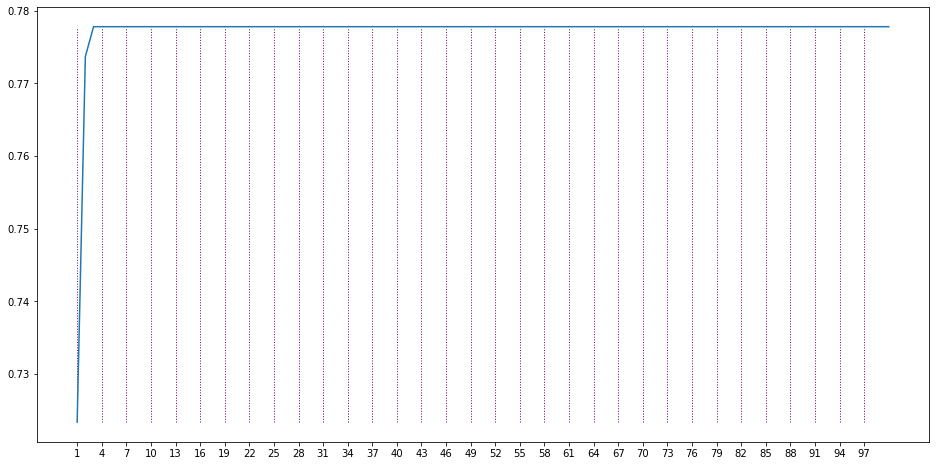

Optimal number of features:  3


('Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Speech Sound Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Diag: No Diagnosis Given


,ROC AUC
1,0.75
2,0.79
3,0.82
4,0.84
5,0.85
6,0.86
7,0.87
8,0.88
9,0.88
10,0.89


Max score:  0.9599792158984141  at  94  features


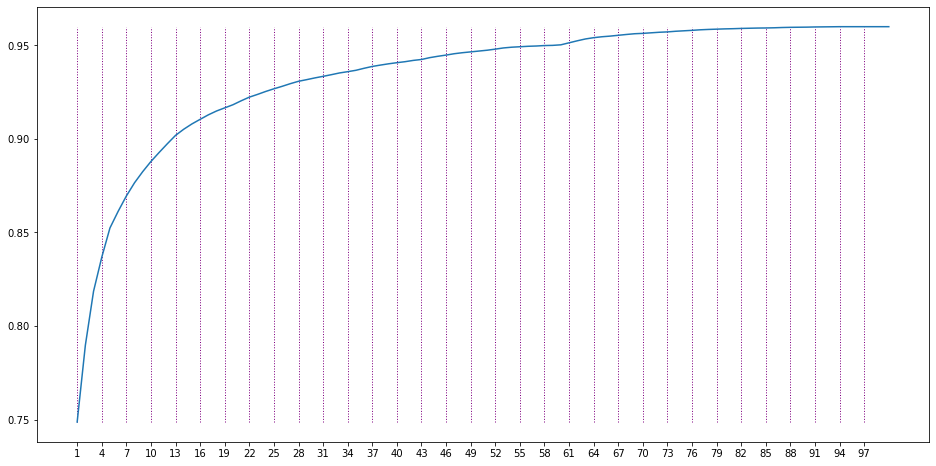

Optimal number of features:  17


('NIH_Scores,NIH7_Flanker',
 'NIH_Scores,NIH7_Pattern',
 'SympChck,CSC_11C',
 'SympChck,CSC_24P',
 'SympChck,CSC_28P',
 'SympChck,CSC_52C',
 'SCQ,SCQ_03',
 'SCQ,SCQ_06',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_b',
 'SRS,SRS_24',
 'DTS,DTS_13',
 'CIS_P,CIS_P_04',
 'CIS_SR,CIS_SR_06',
 'C3SR,C3SR_05',
 'C3SR,C3SR_32',
 'C3SR,C3SR_33')

Diag: Autism Spectrum Disorder


,ROC AUC
1,0.80
2,0.85
3,0.88
4,0.89
5,0.89
6,0.90
7,0.91
8,0.91
9,0.91
10,0.91


Max score:  0.9565428306500406  at  85  features


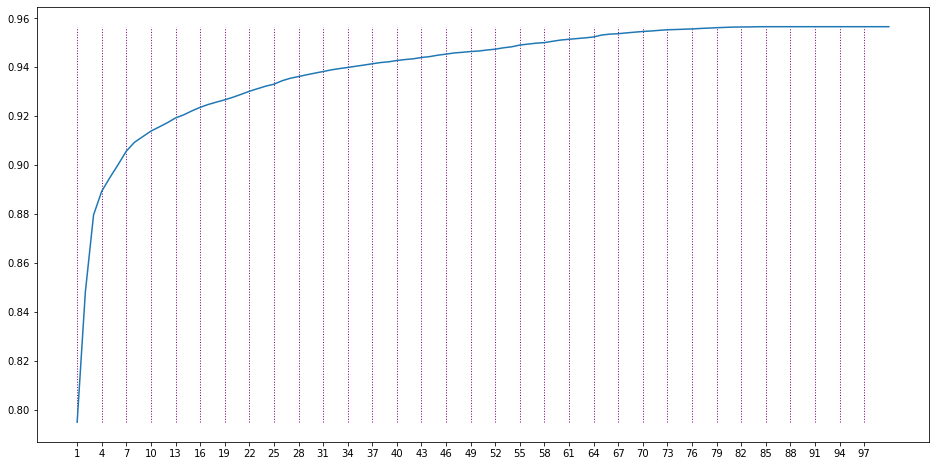

Optimal number of features:  13


('SympChck,CSC_51P',
 'SCQ,SCQ_13',
 'SCQ,SCQ_15',
 'ASSQ,ASSQ_03',
 'ASSQ,ASSQ_06',
 'ASSQ,ASSQ_11',
 'SRS,SRS_13',
 'SRS,SRS_28',
 'SRS,SRS_38',
 'SRS,SRS_55',
 'ICU_P,ICU_P_07',
 'PSI,PSI_14',
 'RBS,RBS_44')

Diag: Specific Learning Disorder with Impairment in Mathematics


,ROC AUC
1,0.66
2,0.76
3,0.77
4,0.78
5,0.79
6,0.79
7,0.80
8,0.80
9,0.80
10,0.80


Max score:  0.8065032461558174  at  22  features


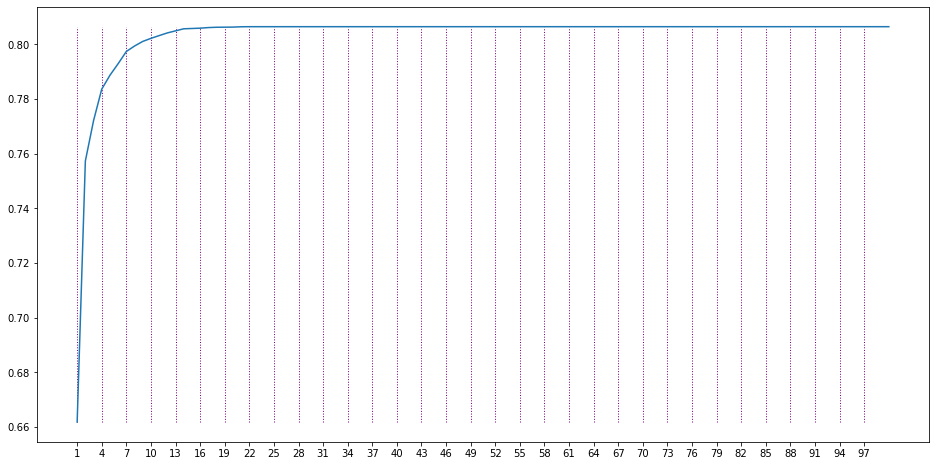

Optimal number of features:  9


('NIH_Scores,NIH7_Flanker',
 'SDQ,SDQ_29_c',
 'PhenX_Neighborhood,PhenX_NS_02',
 'SCARED_SR,SCARED_SR_03',
 'C3SR,C3SR_38',
 'Diag: Agoraphobia',
 'Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: Language Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Diag: ADHD-Combined Type


,ROC AUC
1,0.81
2,0.85
3,0.87
4,0.88
5,0.88
6,0.88
7,0.88
8,0.88
9,0.88
10,0.88


Max score:  0.8808302204432449  at  88  features


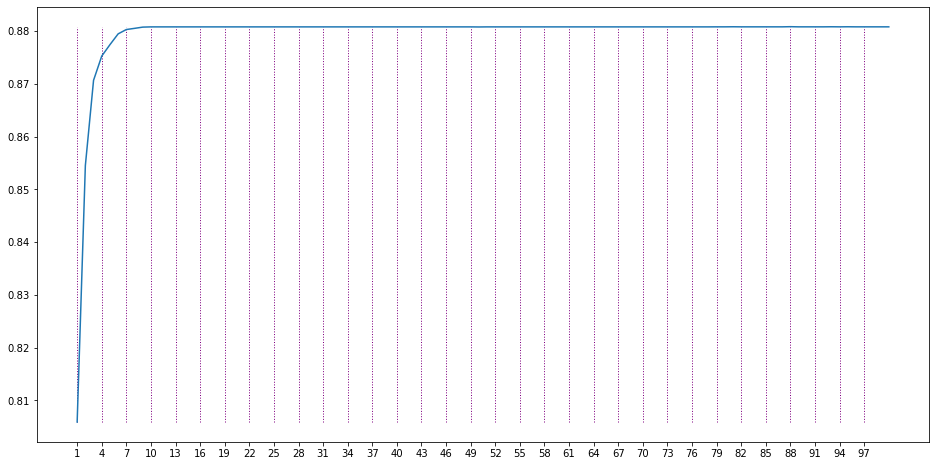

Optimal number of features:  7


('SympChck,CSC_37P',
 'SDQ,SDQ_02',
 'SWAN,SWAN_11',
 'SWAN,SWAN_13',
 'SWAN,SWAN_16',
 'SWAN,SWAN_18',
 'PSI,PSI_36')

Diag: ADHD-Inattentive Type


,ROC AUC
1,0.65
2,0.72
3,0.74
4,0.76
5,0.77
6,0.78
7,0.79
8,0.79
9,0.80
10,0.81


Max score:  0.8335377381742627  at  65  features


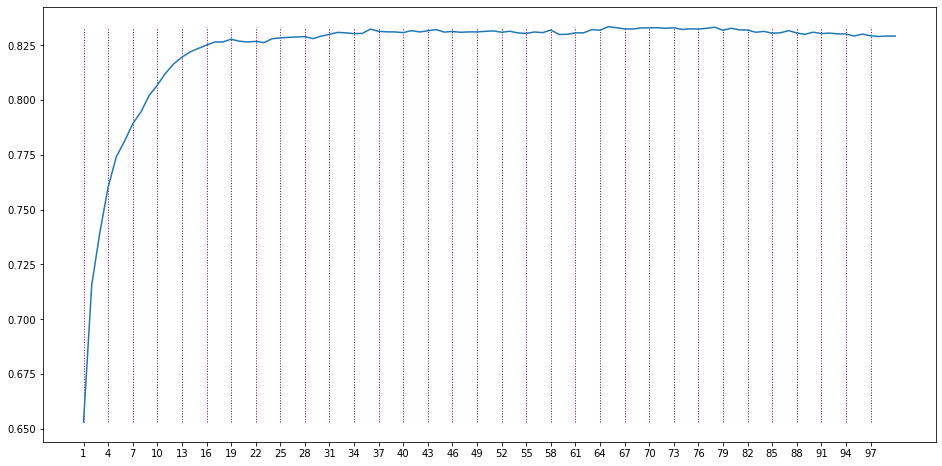

Optimal number of features:  14


('SympChck,CSC_37P',
 'SDQ,SDQ_15',
 'SWAN,SWAN_07',
 'SWAN,SWAN_11',
 'SWAN,SWAN_14',
 'SWAN,SWAN_18',
 'SRS,SRS_05',
 'SRS,SRS_07',
 'SRS,SRS_60',
 'CBCL,CBCL_19',
 'ESWAN,MDD_8A',
 'MFQ_P,MFQ_P_22',
 'PSI,PSI_18',
 'SCARED_SR,SCARED_SR_25')

Diag: Specific Phobia


,ROC AUC
1,0.67
2,0.70
3,0.71
4,0.72
5,0.72
6,0.72
7,0.72
8,0.72
9,0.72
10,0.72


Max score:  0.7242409904174609  at  55  features


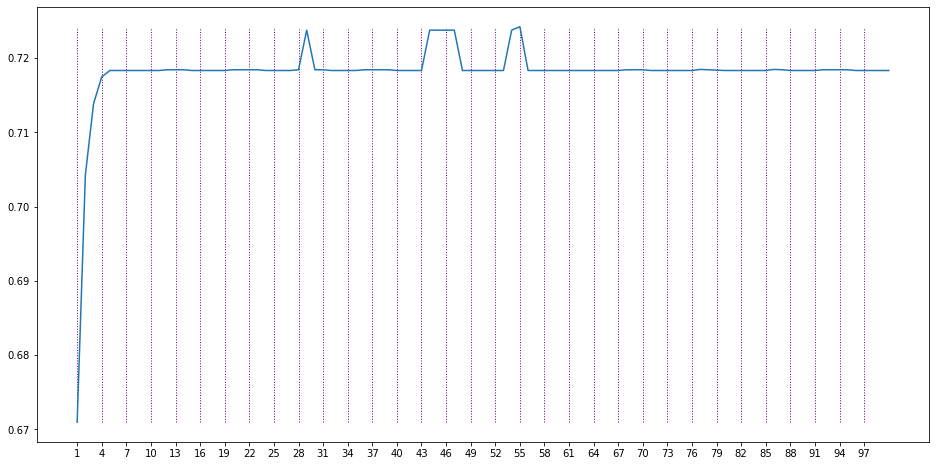

Optimal number of features:  5


('SympChck,CSC_13C',
 'SympChck,CSC_18C',
 'SympChck,CSC_22P',
 'SDQ,SDQ_24',
 'CBCL,CBCL_29')

Diag: Separation Anxiety


,ROC AUC
1,0.74
2,0.80
3,0.81
4,0.84
5,0.84
6,0.85
7,0.85
8,0.86
9,0.86
10,0.86


Max score:  0.8756970627938371  at  34  features


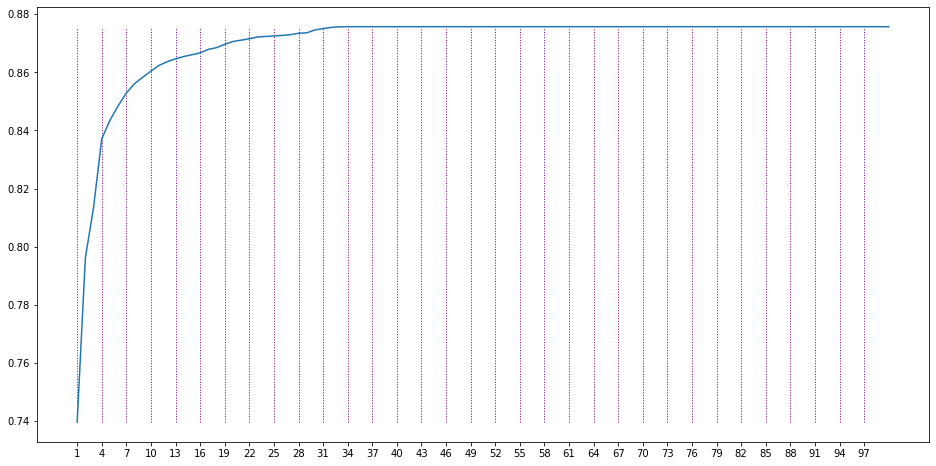

Optimal number of features:  11


('SympChck,CSC_13C',
 'SympChck,CSC_15P',
 'SympChck,CSC_16P',
 'SympChck,CSC_17C',
 'SympChck,CSC_18P',
 'SRS,SRS_43',
 'WHODAS_P,WHODAS_P_04',
 'CIS_P,CIS_P_08',
 'SCARED_SR,SCARED_SR_25',
 'Diag: ADHD-Hyperactive/Impulsive Type',
 'Diag: Enuresis')

Diag: Language Disorder


,ROC AUC
1,0.72
2,0.75
3,0.77
4,0.78
5,0.80
6,0.81
7,0.81
8,0.82
9,0.82
10,0.83


Max score:  0.8427992182258394  at  35  features


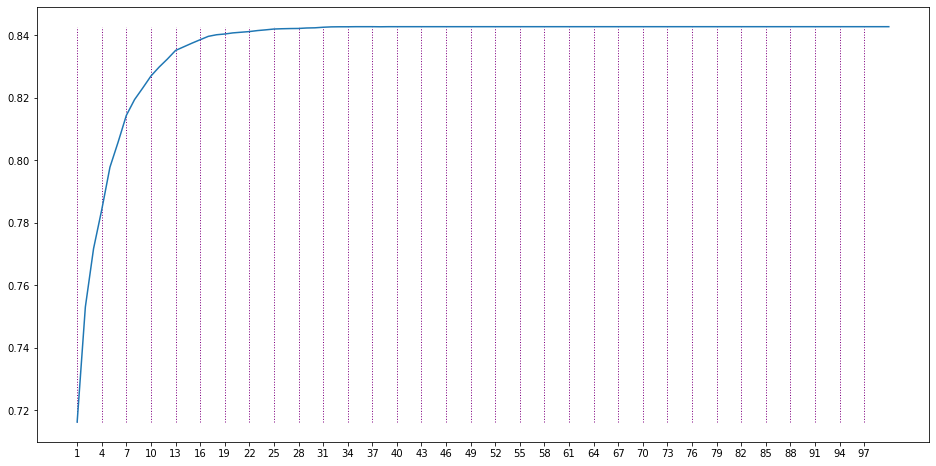

Optimal number of features:  13


('NIH_Scores,NIH7_List',
 'SRS,SRS_07',
 'CBCL,CBCL_79',
 'ICU_P,ICU_P_15',
 'ESWAN,MDD_3A',
 'PSI,PSI_08',
 'PSI,PSI_18',
 'C3SR,C3SR_04',
 'C3SR,C3SR_24',
 'C3SR,C3SR_31',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Speech Sound Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Diag: Social Anxiety (Social Phobia)


,ROC AUC
1,0.70
2,0.76
3,0.79
4,0.81
5,0.83
6,0.84
7,0.84
8,0.85
9,0.85
10,0.86


Max score:  0.9054175828546428  at  46  features


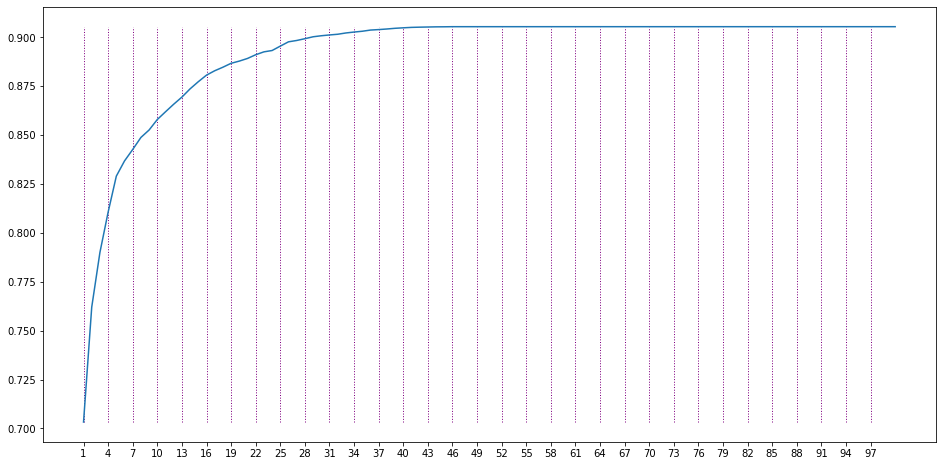

Optimal number of features:  17


('Basic_Demos,Sex',
 'SympChck,CSC_04C',
 'SympChck,CSC_20C',
 'SympChck,CSC_40C',
 'SympChck,CSC_50C',
 'SWAN,SWAN_16',
 'SRS,SRS_18',
 'CBCL,CBCL_07',
 'CBCL,CBCL_71',
 'CBCL,CBCL_75',
 'CBCL,CBCL_93',
 'APQ_P,APQ_P_29',
 'ESWAN,MDD_2B',
 'ESWAN,SocAnx_03',
 'CIS_SR,CIS_SR_06',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Other Specified Anxiety Disorder')

Diag: Oppositional Defiant Disorder


,ROC AUC
1,0.82
2,0.86
3,0.87
4,0.88
5,0.89
6,0.89
7,0.90
8,0.90
9,0.90
10,0.90


Max score:  0.9477105575326216  at  100  features


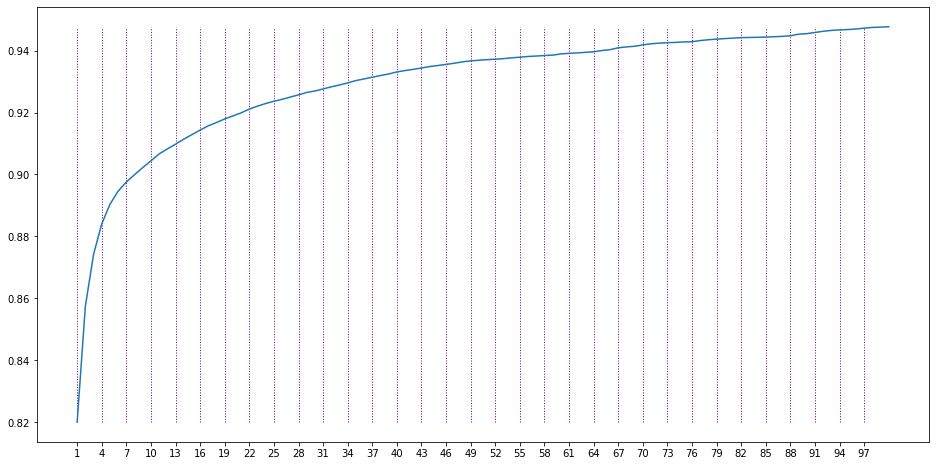

Optimal number of features:  17


('SympChck,CSC_30P',
 'SympChck,CSC_39P',
 'SRS,SRS_65',
 'CBCL,CBCL_13',
 'CBCL,CBCL_22',
 'CBCL,CBCL_56D',
 'CBCL,CBCL_79',
 'ICU_P,ICU_P_04',
 'APQ_P,APQ_P_29',
 'ESWAN,DMDD_3B',
 'CIS_P,CIS_P_13',
 'PSI,PSI_29',
 'APQ_SR,APQ_SR_20A_WAS_MISSING',
 'APQ_SR,APQ_SR_26A_WAS_MISSING',
 'Diag: ADHD-Combined Type',
 'Diag: ADHD-Inattentive Type',
 'Diag: Encopresis')

Diag: Enuresis


,ROC AUC
1,0.79
2,0.87
3,0.89
4,0.90
5,0.90
6,0.90
7,0.91
8,0.91
9,0.91
10,0.91


Max score:  0.9131816869743608  at  20  features


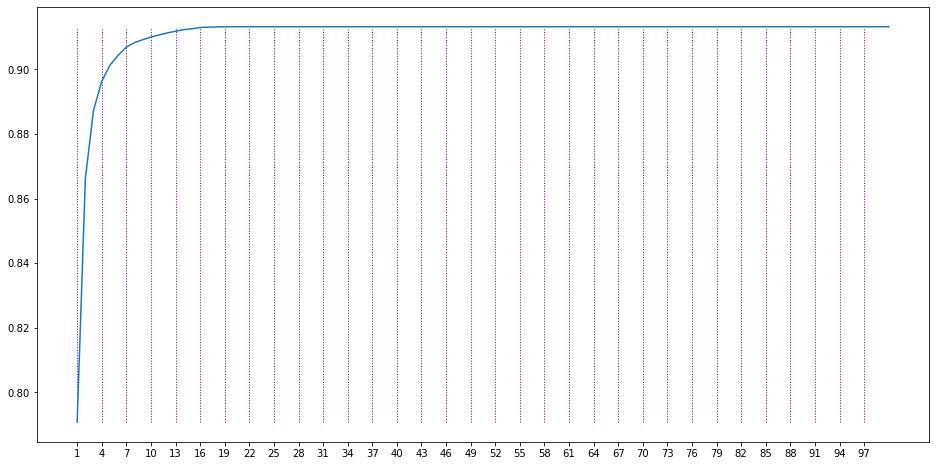

Optimal number of features:  8


('SympChck,CSC_13C',
 'SympChck,CSC_28P',
 'SRS,SRS_41',
 'CBCL,CBCL_08',
 'CBCL,CBCL_108',
 'CBCL,CBCL_23',
 'ESWAN,DMDD_6A',
 'Diag: Separation Anxiety')

Diag: Generalized Anxiety Disorder


,ROC AUC
1,0.75
2,0.79
3,0.81
4,0.82
5,0.83
6,0.84
7,0.84
8,0.85
9,0.85
10,0.86


Max score:  0.8808712298996726  at  36  features


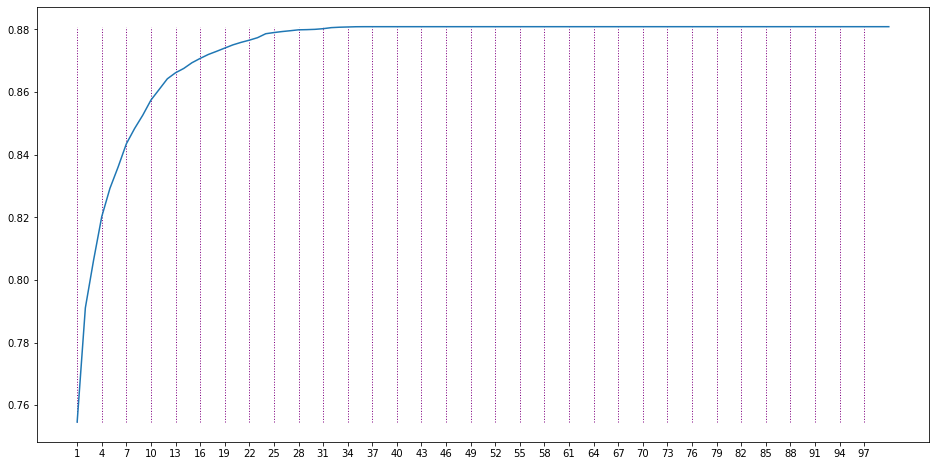

Optimal number of features:  16


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_23C',
 'SCQ,SCQ_36',
 'SDQ,SDQ_08',
 'SDQ,SDQ_17',
 'CBCL,CBCL_45',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_33',
 'APQ_P,APQ_P_41',
 'ESWAN,Panic_A02A',
 'CIS_P,CIS_P_08',
 'RBS,RBS_20',
 'C3SR,C3SR_35',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: Other Specified Anxiety Disorder')

Diag: Major Depressive Disorder


,ROC AUC
1,0.77
2,0.84
3,0.86
4,0.88
5,0.88
6,0.89
7,0.89
8,0.90
9,0.90
10,0.90


Max score:  0.93282124751099  at  83  features


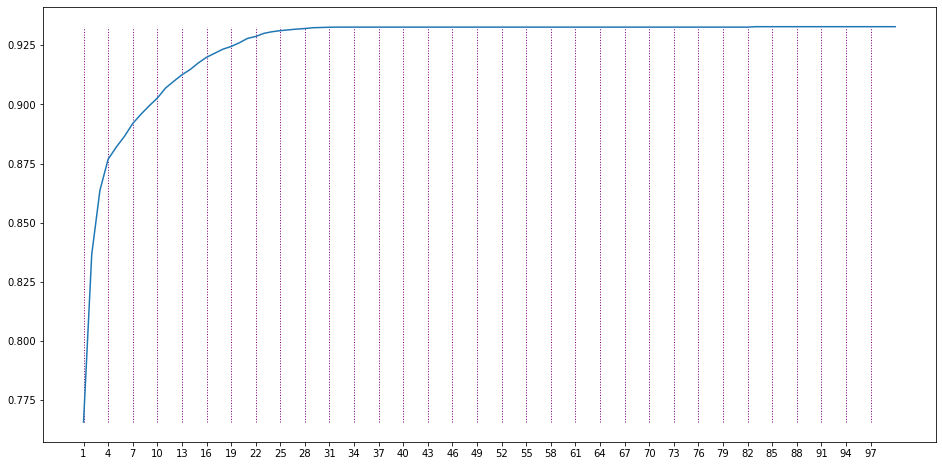

Optimal number of features:  18


('Basic_Demos,Age',
 'SympChck,CSC_01P',
 'SympChck,CSC_30C',
 'SympChck,CSC_49C',
 'ASSQ,ASSQ_14',
 'SRS,SRS_32',
 'SRS,SRS_54',
 'CBCL,CBCL_100',
 'APQ_P,APQ_P_20',
 'PCIAT,PCIAT_14',
 'MFQ_P,MFQ_P_13',
 'APQ_SR,APQ_SR_01',
 'CIS_P,CIS_P_04',
 'CIS_SR,CIS_SR_06',
 'SCARED_SR,SCARED_SR_21',
 'Diag: Cannabis Use Disorder',
 'Diag: Persistent Depressive Disorder (Dysthymia)',
 'Diag: Generalized Anxiety Disorder')

Diag: Specific Learning Disorder with Impairment in Reading


,ROC AUC
1,0.75
2,0.79
3,0.81
4,0.82
5,0.82
6,0.83
7,0.83
8,0.83
9,0.84
10,0.84


Max score:  0.8481468632998501  at  48  features


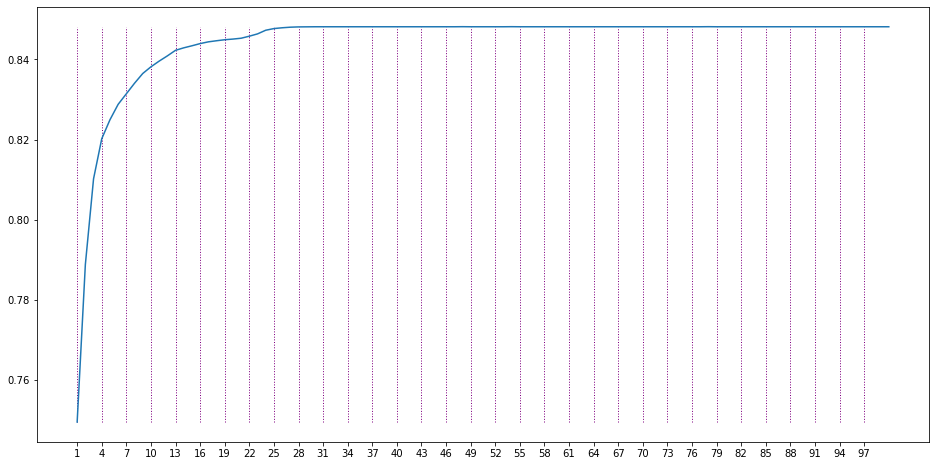

Optimal number of features:  13


('CBCL,CBCL_102',
 'CBCL,CBCL_54',
 'CBCL,CBCL_72',
 'ESWAN,DMDD_10C',
 'APQ_SR,APQ_SR_08',
 'PSI,PSI_18',
 'CIS_SR,CIS_SR_02',
 'SCARED_SR,SCARED_SR_GD',
 'C3SR,C3SR_13',
 'C3SR,C3SR_33',
 'Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Developmental Coordination Disorder')

In [115]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in diags_with_good_performance:
        print(diag)
        diag_classifier = best_classifiers[diag]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
        sfs = sfs.fit(X_train, y_train)

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

In [116]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-cons-new-item-lvl.joblib', compress=1)

Diag: Specific Learning Disorder with Impairment in Written Expression


,ROC AUC
1,0.72
2,0.77
3,0.78
4,0.78
5,0.78
6,0.78
7,0.78
8,0.78
9,0.78
10,0.78


Max score:  0.7778052261747913  at  3  features


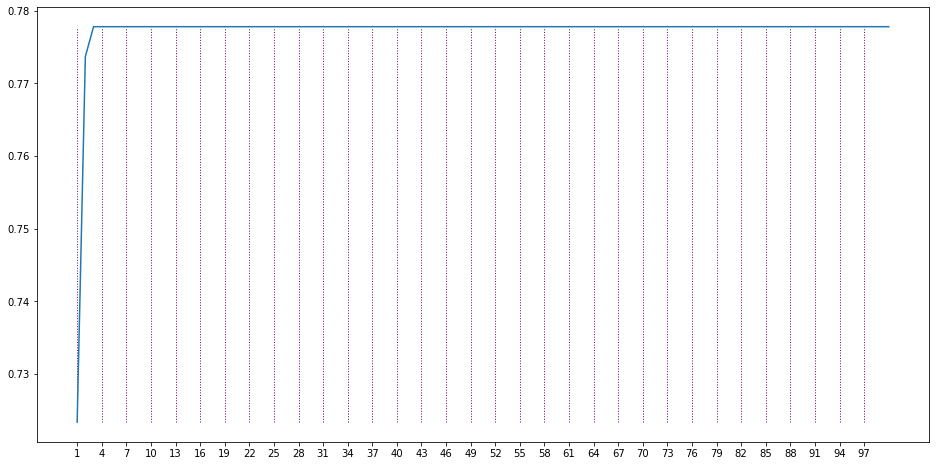

Optimal number of features:  3


('Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Speech Sound Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Score using all features: 


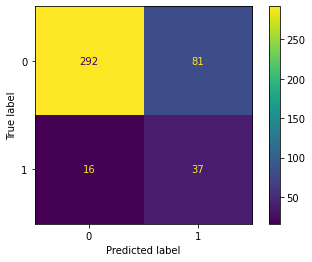

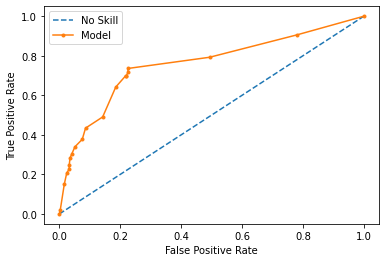

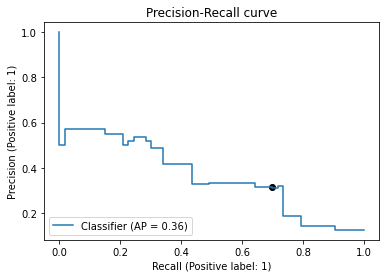

ROC AUC:  0.7584855076129293


ValueError: 'Recall' is not in list

In [117]:
# Print sfs results
for diag in forward_feature_objects:
    print(diag)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    
    X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
    X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train, y_train)
    print("Score using all features: ")
    metrics = get_metrics(new_classifier, threshold, X_test, y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train[features_up_to_optimal], y_train)
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_optimal], y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train[features_up_to_max_score], y_train)
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_max_score], y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])